### Noise Removal with FFT

retrieving "D:\projects\car-license-plate-recognition\doc\problem\placas\141002\Pa140028.jpg.pkz"


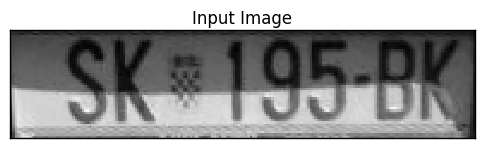

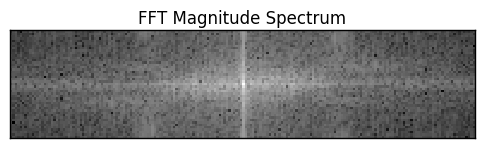

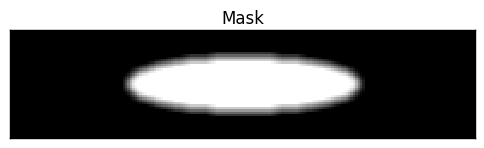

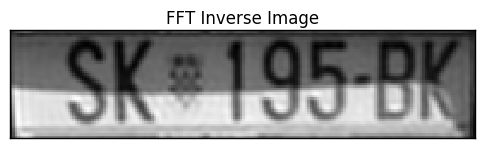

In [3]:
% matplotlib inline

import os
import cv2
import matplotlib.pyplot as plt
from plate import detect, segment, noise, roi
import numpy as np

img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\070603\\P6070049.jpg"
# img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\141002\\Pa140022.jpg"
# img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\141002\\Pa140015.jpg"

img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\280503\\P5280109.jpg"
img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\141002\\Pa140028.jpg"

points = []
points_path = img_path + '.pkz'
if os.path.exists(points_path):
    points = roi.retrieve(points_path, decompress=False)
else:
    print(img_path, ' points file for plate not found')
    exit(1)
    
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plates = segment.segment_plates(img, [points])

gray = cv2.cvtColor(plates[0], cv2.COLOR_RGB2GRAY)
h, w = gray.shape

# magnitude_spectrum = noise.cv2_fft_magnitude(gray) 
dft = cv2.dft(np.float32(gray), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = np.log(1 + cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

f_ishift = np.fft.ifftshift(dft_shift)
img_back = cv2.idft(f_ishift, flags=cv2.DFT_COMPLEX_OUTPUT | cv2.DFT_SCALE)
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.imshow(gray, cmap = 'gray', interpolation='none')
plt.show()

plt.title('FFT Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.imshow(magnitude_spectrum, cmap = 'gray', interpolation='none')
plt.show()

mask = np.zeros((h, w),np.float32)
cv2.ellipse(mask, center=(w>>1, h>>1), axes=(w>>2, h>>2), angle=0, startAngle=0, endAngle=360, color=255, thickness=-1)
mask = cv2.blur(mask, (5,5), borderType=cv2.BORDER_REPLICATE)
mask = cv2.normalize(mask, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)

plt.title('Mask'), plt.xticks([]), plt.yticks([])
plt.imshow(mask, cmap = 'gray', interpolation='none')
plt.show()

mask3d = np.zeros((h, w, 2), np.float32)
mask3d[:, :, 0] = mask[:, :]
mask3d[:, :, 1] = mask[:, :]
dft_shift_masked = dft_shift * mask3d
magnitude_spectrum_masked = np.log(1 + cv2.magnitude(dft_shift_masked[:, :, 0], dft_shift_masked[:, :, 1]))

f_ishift = np.fft.ifftshift(dft_shift_masked)
img_back = cv2.idft(f_ishift, flags=cv2.DFT_COMPLEX_OUTPUT | cv2.DFT_SCALE)
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)

plt.title('FFT Inverse Image'), plt.xticks([]), plt.yticks([])
plt.imshow(img_back, cmap = 'gray', interpolation='none')
plt.show()

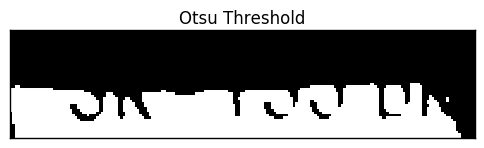

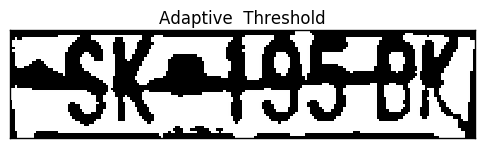

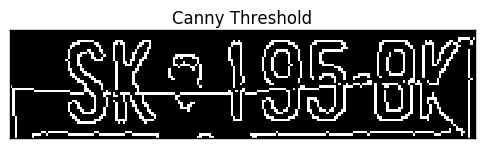

In [71]:
# Otsu
img_back_gray_blurred = cv2.GaussianBlur(img_back_gray, (5, 5), 0)

threshold, img_back_bin = cv2.threshold(img_back_gray_blurred, 0, 255, cv2.THRESH_OTSU)
plt.imshow(img_back_bin, cmap = 'gray', interpolation='none')
plt.title('Otsu Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

# Adaptive
window_size = ((h>>1)<<1) + 1
img_back_bin = cv2.adaptiveThreshold(img_back_gray_blurred, 255, cv2.THRESH_BINARY_INV, cv2.ADAPTIVE_THRESH_MEAN_C, window_size, 0)
plt.imshow(img_back_bin, cmap = 'gray', interpolation='none')
plt.title('Adaptive  Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
 
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
 
    # return the edged image
    return edged

# edges = cv2.Canny(img_back_gray, threshold-10, threshold+10)
edges = auto_canny(img_back_gray_blurred)

plt.imshow(edges, cmap = 'gray', interpolation='none')
plt.title('Canny Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

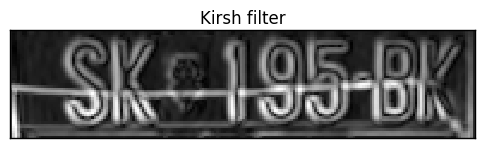

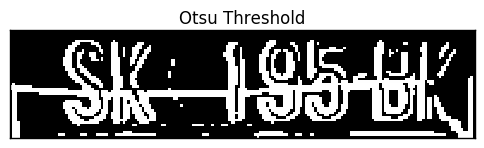

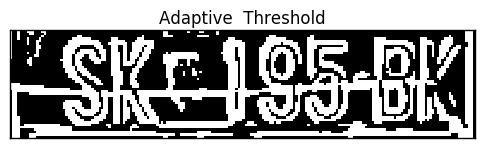

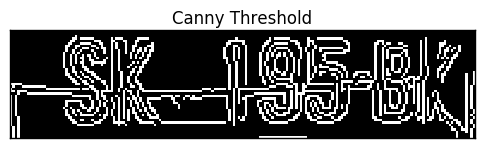

In [73]:
from plate import filters

img_back_gray_blurred = cv2.GaussianBlur(img_back_gray, (5, 5), 0)

img_back_gray_filtered = filters.kirsch_filter(img_back_gray_blurred)
plt.imshow(img_back_gray_filtered, cmap = 'gray', interpolation='none')
plt.title('Kirsh filter'), plt.xticks([]), plt.yticks([])
plt.show()

threshold, img_back_bin = cv2.threshold(img_back_gray_filtered, 0, 255, cv2.THRESH_OTSU)
plt.imshow(img_back_bin, cmap = 'gray', interpolation='none')
plt.title('Otsu Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

# Adaptive
window_size = h
img_back_bin = cv2.adaptiveThreshold(img_back_gray_filtered, 255, cv2.THRESH_BINARY_INV, cv2.ADAPTIVE_THRESH_MEAN_C, window_size, 0)
plt.imshow(img_back_bin, cmap = 'gray', interpolation='none')
plt.title('Adaptive  Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

# edges = cv2.Canny(img_back_gray_filtered, threshold-10, threshold+10)
edges = auto_canny(img_back_gray_filtered)

plt.imshow(edges, cmap = 'gray', interpolation='none')
plt.title('Canny Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

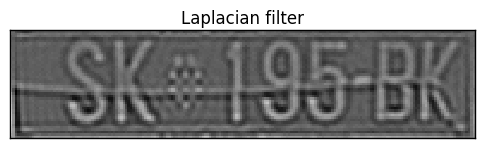

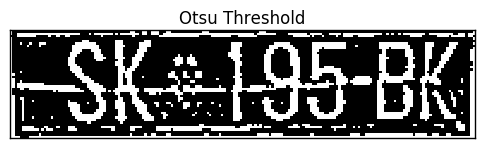

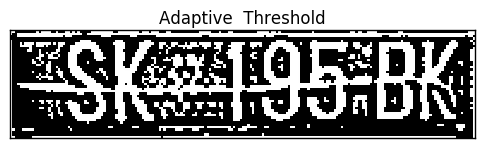

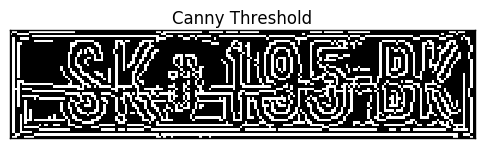

In [74]:
from plate import filters

img_back_gray_blurred = cv2.GaussianBlur(img_back_gray, (3, 3), 0)

img_back_gray_filtered = cv2.Laplacian(img_back_gray_blurred, cv2.CV_64F)
img_back_gray_filtered = cv2.normalize(img_back_gray_filtered, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
plt.imshow(img_back_gray_filtered, cmap = 'gray', interpolation='none')
plt.title('Laplacian filter'), plt.xticks([]), plt.yticks([])
plt.show()

threshold, img_back_bin = cv2.threshold(img_back_gray_filtered, 0, 255, cv2.THRESH_OTSU)
plt.imshow(img_back_bin, cmap = 'gray', interpolation='none')
plt.title('Otsu Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

# Adaptive
window_size = ((h>>1)<<1)+1
img_back_bin = cv2.adaptiveThreshold(img_back_gray_filtered, 255, cv2.THRESH_BINARY_INV, cv2.ADAPTIVE_THRESH_MEAN_C, window_size, 0)
plt.imshow(img_back_bin, cmap = 'gray', interpolation='none')
plt.title('Adaptive  Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

# edges = cv2.Canny(img_back_gray_filtered, threshold-10, threshold+10)
edges = auto_canny(img_back_gray_filtered)

plt.imshow(edges, cmap = 'gray', interpolation='none')
plt.title('Canny Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

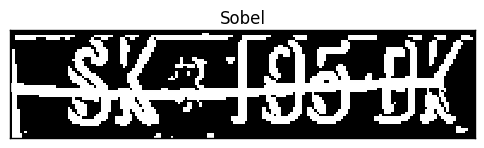

In [79]:
img_back_gray_blurred = cv2.GaussianBlur(img_back_gray, (3, 3), 0)

sobel_x = cv2.Sobel(img_back_gray_blurred, cv2.CV_64F, 1, 0, ksize=3)
sobel_x = cv2.normalize(sobel_x, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
_, sobel_x_bin = cv2.threshold(sobel_x, 0, 255, cv2.THRESH_OTSU)
sobel_y = cv2.Sobel(img_back_gray_blurred, cv2.CV_64F, 0, 1, ksize=3)
sobel_y = cv2.normalize(sobel_y, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
_, sobel_y_bin = cv2.threshold(sobel_y, 0, 255, cv2.THRESH_OTSU)
sobel = cv2.bitwise_or(sobel_x_bin, sobel_y_bin)

# abs_grad_y = cv2.convertScaleAbs(grad_y)
# img_back_gray_filtered = cv2.addWeighted(abs_grad_x,0.5,abs_grad_y,0.5,0)

plt.imshow(sobel, cmap = 'gray', interpolation='none')
plt.title('Sobel'), plt.xticks([]), plt.yticks([])
plt.show()

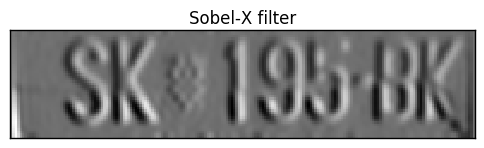

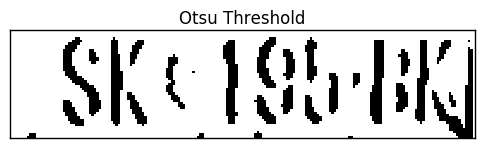

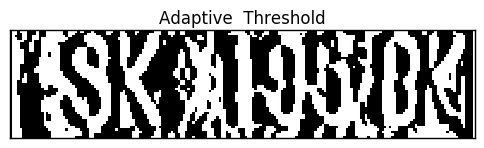

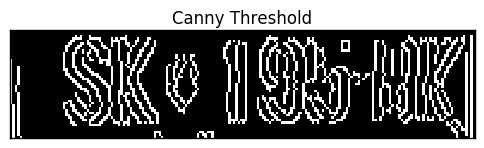

In [85]:
img_back_gray_blurred = cv2.GaussianBlur(img_back_gray, (3, 3), 0)# abs_grad_x = cv2.convertScaleAbs(grad_x)

img_back_gray_filtered = cv2.Sobel(img_back_gray_blurred, cv2.CV_64F, 1, 0, ksize=5)
img_back_gray_filtered = cv2.normalize(img_back_gray_filtered, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
plt.imshow(img_back_gray_filtered, cmap = 'gray', interpolation='none')
plt.title('Sobel-X filter'), plt.xticks([]), plt.yticks([])
plt.show()

threshold, img_back_bin = cv2.threshold(img_back_gray_filtered, 0, 255, cv2.THRESH_OTSU)
plt.imshow(img_back_bin, cmap = 'gray', interpolation='none')
plt.title('Otsu Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

# Adaptive
window_size = ((h>>1)<<1)+1
img_back_bin = cv2.adaptiveThreshold(img_back_gray_filtered, 255, cv2.THRESH_BINARY_INV, cv2.ADAPTIVE_THRESH_MEAN_C, window_size, 0)
plt.imshow(img_back_bin, cmap = 'gray', interpolation='none')
plt.title('Adaptive  Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

# edges = cv2.Canny(img_back_gray_filtered, threshold-10, threshold+10)
edges = auto_canny(img_back_gray_filtered)

plt.imshow(edges, cmap = 'gray', interpolation='none')
plt.title('Canny Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

### MEDIAN BLUR

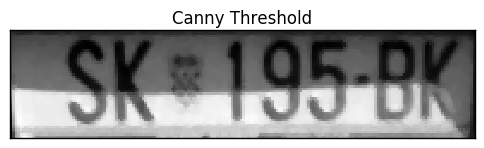

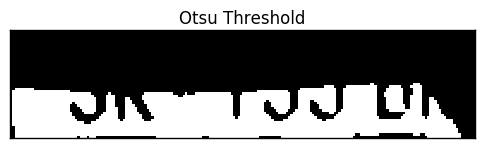

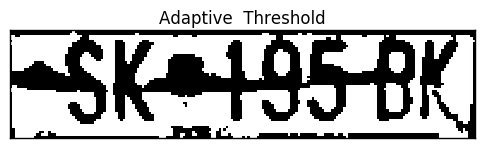

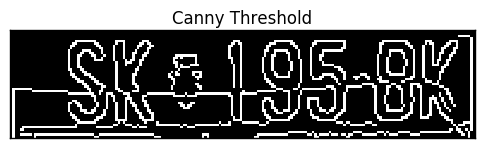

In [87]:
gray_smooth = cv2.medianBlur(gray, 3)

plt.imshow(gray_smooth, cmap = 'gray', interpolation='none')
plt.title('Median Blur'), plt.xticks([]), plt.yticks([])
plt.show()

threshold, img_back_bin = cv2.threshold(gray_smooth, 0, 255, cv2.THRESH_OTSU)
plt.imshow(img_back_bin, cmap = 'gray', interpolation='none')
plt.title('Otsu Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

window_size = ((h>>1)<<1)+1
img_back_bin = cv2.adaptiveThreshold(gray_smooth, 255, cv2.THRESH_BINARY_INV, cv2.ADAPTIVE_THRESH_MEAN_C, window_size, 0)
plt.imshow(img_back_bin, cmap = 'gray', interpolation='none')
plt.title('Adaptive  Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

edges = auto_canny(gray_smooth)
plt.imshow(edges, cmap = 'gray', interpolation='none')
plt.title('Canny Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

### BILATERAL FILTERING

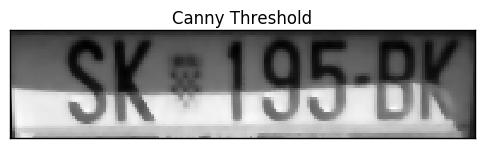

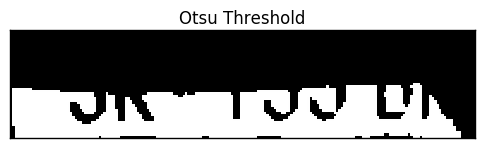

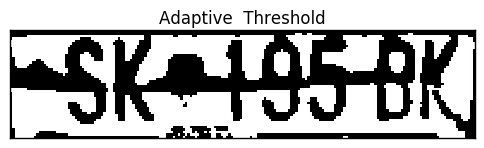

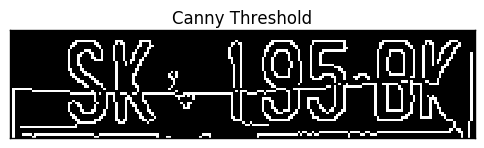

In [98]:
wsize = gray.shape[0]>>3
gray_smooth = cv2.bilateralFilter(gray, wsize, 30, wsize)

plt.imshow(gray_smooth, cmap = 'gray', interpolation='none')
plt.title('Canny Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

threshold, img_back_bin = cv2.threshold(gray_smooth, 0, 255, cv2.THRESH_OTSU)
plt.imshow(img_back_bin, cmap = 'gray', interpolation='none')
plt.title('Otsu Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

window_size = ((h>>1)<<1)+1
img_back_bin = cv2.adaptiveThreshold(gray_smooth, 255, cv2.THRESH_BINARY_INV, cv2.ADAPTIVE_THRESH_MEAN_C, window_size, 0)
plt.imshow(img_back_bin, cmap = 'gray', interpolation='none')
plt.title('Adaptive  Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

edges = auto_canny(gray_smooth)
plt.imshow(edges, cmap = 'gray', interpolation='none')
plt.title('Canny Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
import cv2
import numpy as np, sys

# generate Gaussian pyramid for A
G = img.copy()
gpA = [G]
for i in range(3):
    G = cv2.pyrDown(G)
    gpA.append(G)

plt.figure(figsize=(20, 20))
plt.subplot(1, 4, 1), plt.imshow(img, cmap='gray')
plt.title('Image'), plt.xticks([]), plt.yticks([])
for i in range(3):
    plt.subplot(1, 4, i + 1 +1), plt.imshow(gpA[i], cmap='gray')
    plt.title('Image pyramid/2'), plt.xticks([]), plt.yticks([])

plt.show()

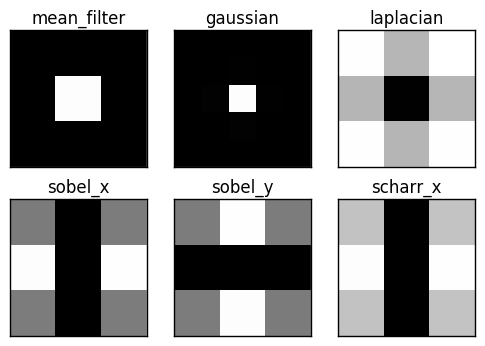

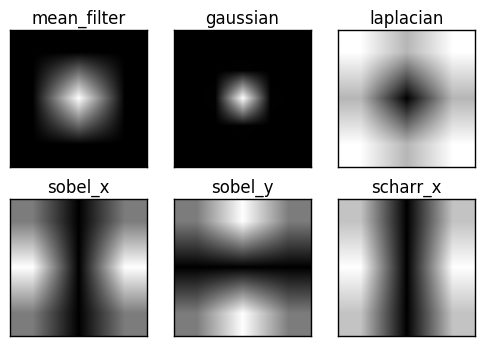

In [32]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# simple averaging filter without scaling parameter
mean_filter = np.ones((3,3))

# creating a guassian filter
x = cv2.getGaussianKernel(5,10)
gaussian = x*x.T

# different edge detecting filters
# scharr in x-direction
scharr = np.array([[-3, 0, 3],
                   [-10,0,10],
                   [-3, 0, 3]])
# sobel in x direction
sobel_x= np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
# sobel in y direction
sobel_y= np.array([[-1,-2,-1],
                   [0, 0, 0],
                   [1, 2, 1]])
# laplacian
laplacian=np.array([[0, 1, 0],
                    [1,-4, 1],
                    [0, 1, 0]])

filters = [mean_filter, gaussian, laplacian, sobel_x, sobel_y, scharr]
filter_name = ['mean_filter', 'gaussian','laplacian', 'sobel_x', \
                'sobel_y', 'scharr_x']
fft_filters = [np.fft.fft2(x) for x in filters]
fft_shift = [np.fft.fftshift(y) for y in fft_filters]
mag_spectrum = [np.log(np.abs(z)+1) for z in fft_shift]

for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(mag_spectrum[i],cmap = 'gray', interpolation='none')
    plt.title(filter_name[i]), plt.xticks([]), plt.yticks([])
plt.show()

for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(mag_spectrum[i],cmap = 'gray')
    plt.title(filter_name[i]), plt.xticks([]), plt.yticks([])
    
plt.show()

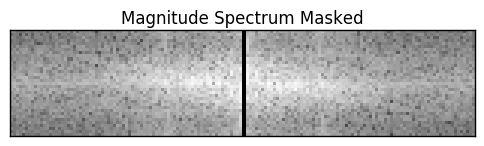

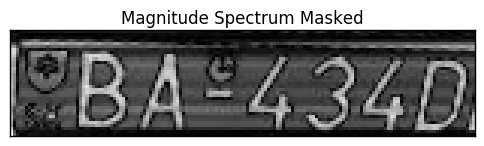

In [32]:
rows, cols = gray.shape
crow = int(rows/2)
ccol = int(cols/2)
h, w = gray.shape

# generate mask
mask = np.zeros((rows, cols),np.uint8)
# cv2.ellipse(mask, center=(int(cols/2), int(rows/2)), axes=(int(cols/4), int(rows/4)), angle=0, startAngle=0, endAngle=360, color=255, thickness=-1)
cv2.line(mask, (w>>1, 0), (w>>1, h), 255, 1)
# cv2.line(mask, (0, h>>1), (w, h>>1), 255, 5)
mask = cv2.bitwise_not(mask)

# convert to mask3d 
mask[mask==255] = 1
mask3d =  np.zeros((rows, cols, 2),np.uint8)
mask3d[:,:,0] = mask[:,:]
mask3d[:,:,1] = mask[:,:]

# calc inverse
dft_shift_masked = dft_shift*mask3d
magnitude_spectrum_masked = np.log(1+cv2.magnitude(dft_shift_masked[:,:,0],dft_shift_masked[:,:,1]))
f_ishift = np.fft.ifftshift(dft_shift_masked)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

plt.subblot(112)
plt.title('Magnitude Spectrum Masked'), plt.xticks([]), plt.yticks([])
plt.imshow(magnitude_spectrum_masked, cmap = 'gray', interpolation='none')
plt.show()

plt.title('Inverse Image'), plt.xticks([]), plt.yticks([])
plt.imshow(img_back, cmap = 'gray', interpolation='none')
plt.show()

In [ ]:
# f_ishift = np.fft.ifftshift(fshift_masked)
# img_back = cv2.idft(f_ishift)
# img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

# plt.title('Output Image'), plt.xticks([]), plt.yticks([])
# plt.imshow(img_back, cmap = 'gray', interpolation='none')
# plt.show()



# # create a mask first, center square is 1, remaining all zeros
# mask = np.zeros((rows,cols,2),np.uint8)
# mask[crow-10:crow+10, ccol-50:ccol+50] = 1

# # apply mask and inverse DFT
# fshift_mask = dft_shift*mask
# f_ishift = np.fft.ifftshift(fshift_mask)
# img_back = cv2.idft(f_ishift)
# img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

# plt.imshow(img_back, cmap = 'gray', interpolation='none')
# plt.title('Image Reconstructed'), plt.xticks([]), plt.yticks([])
# plt.show()

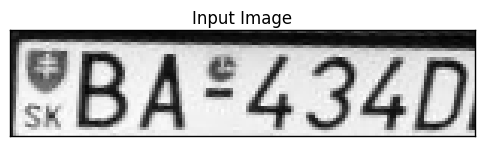

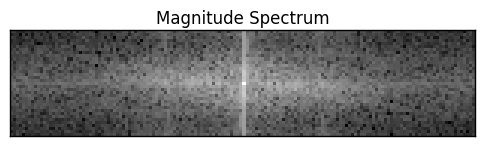

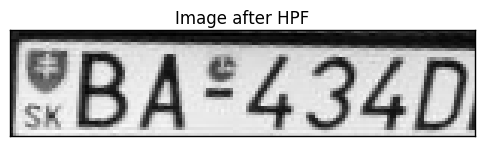

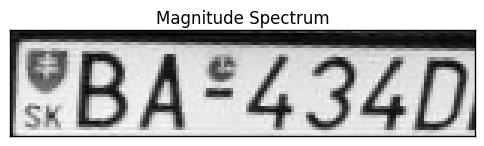

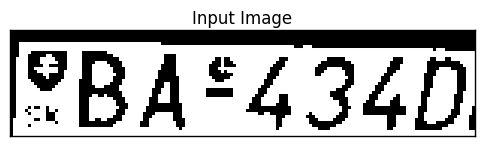

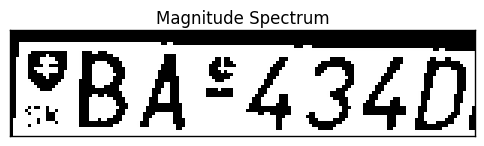

In [71]:
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.imshow(img, cmap = 'gray', interpolation='none')
plt.show()

plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.imshow(magnitude_spectrum, cmap = 'gray', interpolation='none')
plt.show()

rows, cols = img.shape
crow,ccol = int(rows/2) , int(cols/2)
# print(crow, ccol)
fshift[crow-20:crow+20, ccol-5:ccol+5] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.imshow(img_back, cmap = 'gray', interpolation='none')
plt.show()

# http://docs.opencv.org/2.4.8/modules/core/doc/operations_on_arrays.html#normalize
img_back_gray = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
plt.imshow(img_back_gray, cmap = 'gray', interpolation='none')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

_, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
_, img_back_bin = cv2.threshold(img_back_gray, 0, 255, cv2.THRESH_OTSU)

plt.imshow(img_bin, cmap = 'gray', interpolation='none')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.show()

plt.imshow(img_back_bin, cmap = 'gray', interpolation='none')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

(35, 154)


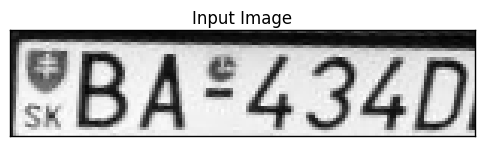

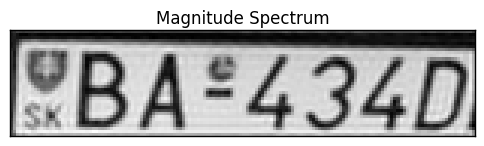

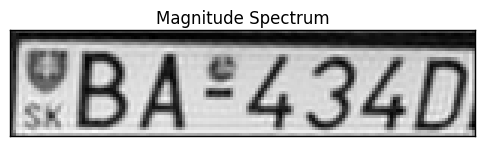

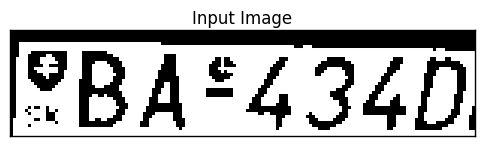

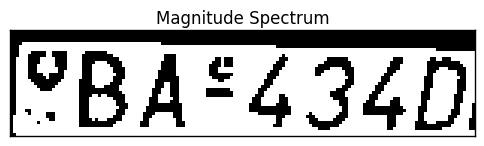

In [67]:
rows, cols = img.shape
crow,ccol = int(rows/2), int(cols/2)

print(img.shape)

# create a mask first, center square is 1, remaining all zeros
mask = np.zeros((rows,cols,2),np.uint8)
mask[crow-10:crow+10, ccol-50:ccol+50] = 1

# apply mask and inverse DFT
fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

plt.imshow(img, cmap = 'gray', interpolation='none')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.show()

plt.imshow(img_back, cmap = 'gray', interpolation='none')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

# http://docs.opencv.org/2.4.8/modules/core/doc/operations_on_arrays.html#normalize
img_back_gray = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
plt.imshow(img_back_gray, cmap = 'gray', interpolation='none')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

_, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
_, img_back_bin = cv2.threshold(img_back_gray, 0, 255, cv2.THRESH_OTSU)

plt.imshow(img_bin, cmap = 'gray', interpolation='none')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.show()

plt.imshow(img_back_bin, cmap = 'gray', interpolation='none')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()